Your owe a bike store. During week $t$, the (random) demand is $D_t$ units. 
On Monday morning you may choose to command $a_t$ additional units: they are delivered immediately before the shop opens. For each week:

  * Maintenance cost: $h(s)$ for $s$ units in stock left from the previous week (no maintenance is needed for newly commanded items)
  * Command cost: $C(a)$ for $a$ units
  * Sales profit: $f(q)$ for $q$ units sold
  * Constraint: 
    - your warehouse has a maximal capacity of $M$ unit (any additionnal bike gets stolen)
    - you cannot sell bikes that you don't have in stock


* State: number of bikes in stock left from the last week => state space $\mathcal{S} = \{0,\dots, M\}$
* Action: number of bikes commanded at the beginning of the week => action space $\mathcal{A} = \{0, \dots ,M\}$ 
* Reward = balance of the week: if you command $A_t$ bikes,
$$X_t = - C(A_t) - h(S_t) + f\big(\min(D_t, S_t+A_t, M) \big)$$
* Transitions: you end the week with $S_{t+1} = \max\big(0, \min(M, S_t + A_t)  - D_t \big)$ bikes

* State: number of bikes in stock left from the last week => state space $\mathcal{S} = \{0,\dots, M\}$
* Action: number of bikes commanded at the beginning of the week => action space $\mathcal{A} = \{0, \dots ,M\}$ 
* Reward = balance of the week: if you command $A_t$ bikes,
$$X_t = - C(A_t) - h(S_t) + f\big(\min(D_t, S_t+A_t, M) \big)$$
* Transitions: you end the week with $S_{t+1} = \max\big(0, \min(M, S_t + A_t)  - D_t \big)$ bikes

Here we assume that $h(s) = h\cdot s$, $f(q) = p\cdot q$, $C(a) = c_0 \mathbb{1}\{a>0\} + c\cdot a$

In [1]:
%pylab

## Constants of the problem
M = 15 # stock capacity
h = 0.3 # maintenance cost per unit and per week-end
p = 1 # selling price per unit
c0 = 0.8 # shpping cost per command
c = 0.5 # buying price per unit

s0 = M # initial stock
gamma = 0.99 # discount factor: I do not care what happens after more than 100 weeks (but in fact the optimal policy has a limit when gamma tends to 1)

## The demand 

avgdem = 9 # average demand
# demande distribution function (everything >=M is grouped together since at most M bikes can be sold anyway)
# pdem = [exp(-avgdem) * avgdem^(big(k)) / factorial(big(k)) for k in 0:M] # Poisson demand (small tail)
pdem = [1/(1+avgdem)*(1-1/(1+avgdem))**k for k in range(M+1)]# Exponential demand (large tail)
pdem[M] = 1 - sum(pdem[0:M])
cpdem = cumsum(pdem)
def rdemand():
    u = random.random()# random demand generator
    return( sum(u>cpdem) )

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Transition and Reward functions

def reward(s, a, d):
    return( -h*(s) -c0*(a>0) - c*a + p * min(d, s+a, M) )

def nextState(s, a, d):
    return( max(0, min(M, s+a)-d) )

def simu(T, pi):
    X = zeros(T+1)
    S = s0
    for t in range(T+1):
        A = pi(S)
        D = rdemand()
        X[t] = reward(S, A, D)
        S = nextState(S, A, D)
    return(X)


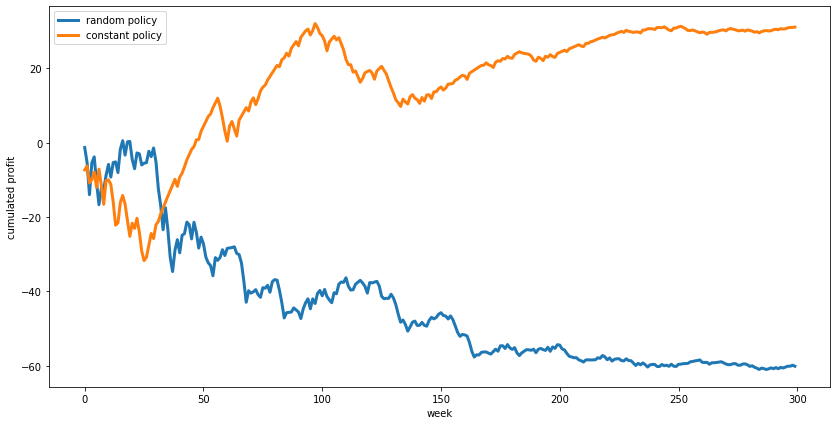

In [3]:
# Simulation: comparing two (basic) policies

def randomPolicy(s):
    return( random.choice(range(M+1)) )

def constantPolicy(s):
    return(6)

T = int(3/(1-gamma))
X1 = simu(T, randomPolicy)
X2 = simu(T, constantPolicy)


figure(figsize = [14, 7])
plotDiscount = True
if plotDiscount:
    plot(cumsum(X1 * [gamma**t for t in range(T+1)]), linewidth=3)
    plot(cumsum(X2* [gamma**t for t in range(T+1)]), linewidth=3)
    legend(["random policy", "constant policy"])
    xlabel("week")
    ylabel("cumulated profit")
else:
    plot(cumsum(X1), linewidth=3)#
    plot(cumsum(X2), linewidth=3) 
    legend(["random policy", "constant policy"])
    xlabel("week")
    ylabel("cumulated profit")
    


In [4]:
# Transition and Reward kernels
K = dict() # K[s,a][ns] = probability to skip from state s to state ns for the action a
avgR = dict() # avgR[s,a] = average reward received in state s when playing action a

## initialization
for a in range(M+1):
    for s in range(M+1):
        K[s,a] = zeros(1+M)
        avgR[s,a] = 0


## computation: iterate over all possible states, actions, and possible demand values
for a in range(M+1):
    for s in range(M+1):
        for d in range(M+1):
            ns = nextState(s, a, d)
            K[s,a][ns] += pdem[d]
            avgR[s,a] += pdem[d] * reward(s, a, d)


In [5]:
# Markov transition matrix of a *deterministic* policy pi

def policyTransitionMatrix(pi): # warning: requires pi to be *deterministic*
    Kpi = zeros((1+M, 1+M))
    for s in range(M+1):
        Kpi[s,:] = K[s, pi(s)]
    return(Kpi)


def policyAvgReward(pi):
    avgRpi = zeros(1+M)
    for s in range(M+1):
        avgRpi[s] = avgR[s, pi(s)]
    return(avgRpi)
  
# example: for the constant policy
# Kpi = policyTransitionMatrix(constantPolicy)
# avgRpi = policyAvgReward(constantPolicy)

# policy evaluation

def evaluatePolicy(pi):
    Kpi = policyTransitionMatrix(pi)
    avgRpi = policyAvgReward(pi)
    return(solve(identity(M+1) - gamma * Kpi, avgRpi) )

evaluatePolicy(constantPolicy)

array([47.53820009, 47.68531763, 47.76434917, 47.77853042, 47.73159355,
       47.62965037, 47.4782015 , 47.28219752, 47.04609394, 46.77390072,
       46.47390072, 46.17390072, 45.87390072, 45.57390072, 45.27390072,
       44.97390072])

## Planning

In [6]:
# Bellmann Operator
def BellmannOperator(V): # TODO maybe: merge BellmannOperator and greedyPolicy by having BellmannOperator return the associated policy
    nV = copy(V)    
    for s in range(M+1):
        nV[s] = max([avgR[s, a] + gamma * dot(K[s,a], V) for a in range(M+1)]) 
    return(nV)

# Value Iteration
def valueIteration(epsilon=1e-6): # epsilon = guaranteed precision
    V = zeros(1+M)  # in theory, can be anything
    oV = [v + 2*epsilon for v in V]
    while norm(V-oV, inf) > epsilon*(1-gamma)/gamma:
        oV = copy(V)
        V = BellmannOperator(V)
    return(V)

def greedyPolicy(V):
    pi = arange(M+1)# zeros(M+1)
    for s in range(M+1):
        w = [avgR[s, a] + gamma * dot(K[s,a], V) for a in range(M+1)]
        pi[s] = w.index(max(w))
    return(pi)

optimalValue = valueIteration()
print(optimalValue)
piOpt = greedyPolicy(optimalValue)
print(piOpt)

[118.22021144 118.42021144 118.62021144 118.82021144 119.12239576
 119.52292585 119.88971505 120.22280083 120.52222058 120.78801168
 121.02021144 121.21885715 121.38398606 121.51563535 121.61384219
 121.6786437 ]
[10  9  8  7  0  0  0  0  0  0  0  0  0  0  0  0]


In [7]:
# Policy Iteration
def policyIteration():
    pi = random.choice(M+1, 1+M)
    opi = (M+1)*ones(1+M)
    while any(pi!=opi):
        opi = copy(pi)
        V = evaluatePolicy(lambda x:pi[x])
        pi = greedyPolicy(V)
    return(pi)

policyIteration()

array([10,  9,  8,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

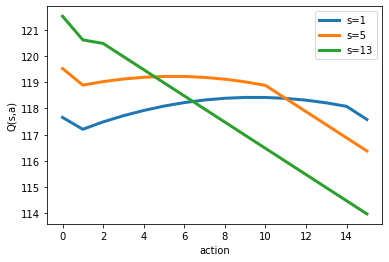

In [8]:
# computing the optimal Q-table
optimalQ = zeros((M+1, M+1))
for s in range(M+1):
    for a in range(M+1):
        optimalQ[s, a]= avgR[s, a] + gamma * sum([K[s, a][ns] * optimalValue[ns] for ns in range(M+1) ])

lS = [1, int(floor(M/3)), M-2]
for s in lS:
    plot(range(M+1), optimalQ[s, :], linewidth=3)
xlabel("action") 
ylabel("Q(s,a)")
legend(["s="+str(x) for x in lS]);


## Stochastic Approximation for Policy Evaluation: TD(0) and TD($\lambda$)

In [9]:
def TD0(pi, T):
    V = zeros(1+M) # V[S] = estimated value of each state under policy pi
    V = 46*ones(1+M) # cheating a little (see comment at the end)
    N = zeros(1+M) # N[S] = number of visits to state s in the loop
    S = s0
    for t in range(T):
        N[S] = N[S] + 1
        A = pi(S)
        D = rdemand()
        X = reward(S, A, D)
        nS = nextState(S, A, D) 
        alpha = 1/(1+N[S])**0.5 
        V[S] = (1-alpha)*V[S] + alpha * (X + gamma*V[nS])
        S = nS
    return(V)

T = 10**6
print(TD0(constantPolicy, T))
print(evaluatePolicy(constantPolicy))
# requires a huge number of iterations to converge... at least 10^7
# because the initialization is too far from the solution: it takes forever to raise from 0 to 47

[47.93003137 47.98471526 47.92031067 48.07103879 48.14882099 48.06137495
 48.07997386 47.8629625  47.61474379 47.0309938  46.84153945 46.67741362
 46.50043005 46.62209525 45.49887849 46.16562477]
[47.53820009 47.68531763 47.76434917 47.77853042 47.73159355 47.62965037
 47.4782015  47.28219752 47.04609394 46.77390072 46.47390072 46.17390072
 45.87390072 45.57390072 45.27390072 44.97390072]


# Model-free Learning: Q-learning

In [10]:
def Qlearning(T):
    # Q = zeros((1+M, 1+M) # Q-table
    Q = 118*ones((1+M, 1+M)) # Q-table cheating with initialization
    N = zeros(1+M) # number of visits to state s # rather take state-value?
    epsilon = 0.3
    S = s0
    for t in range(T):
        if mod(t, floor(T/10))==0:
            print(int(100*t/T), "%\t", sep=''); 
            if t==T:
                print("")
        N[S] = N[S] + 1
        if random.random()<epsilon: # /t^(1/4) # epsilon-greedy choice of action
            A = random.choice(M+1)
        else:
            w = Q[S, :].tolist()
            A = w.index(max(w)) # greedy action            

        D = rdemand()
        X = reward(S, A, D)
        nS = nextState(S, A, D)
        delta = X + gamma * max(Q[nS, :]) - Q[S, A]
        alpha = 1/(1+N[S])**0.5 # alpha = 1/t^0.3 # warning: alpha should not be taken for an integer...
        Q[S, A] = Q[S, A] + alpha * delta
        S = nS        

    pi = zeros(M+1)
    for s in range(M+1):
        w = Q[s,:].tolist()
        pi[s] = w.index(max(w))
    return(pi)

T = 10**6
pi = Qlearning(T)
print(pi)
print(evaluatePolicy(lambda s:pi[s]))
print(optimalValue)


# for T >= 10^7, we obtain correct policies
# for T >= 10^8, we almost obtain the right one

0%	
10%	
20%	
30%	
40%	
50%	
60%	
70%	
80%	
90%	
[11.  8.  9.  9.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[117.83347294 118.00177058 118.23347294 118.39902958 118.7340041
 119.13496525 119.50218505 119.83570094 120.13555033 120.40177058
 120.63439903 120.83347294 120.99902958 121.13110613 121.22973975
 121.29496756]
[118.22021144 118.42021144 118.62021144 118.82021144 119.12239576
 119.52292585 119.88971505 120.22280083 120.52222058 120.78801168
 121.02021144 121.21885715 121.38398606 121.51563535 121.61384219
 121.6786437 ]
